In [26]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import seaborn as sns
import random
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {device}")

using PyTorch version: 2.6.0+cu124, Device: cuda


In [3]:
# pollution dataset

df_summary = pd.read_csv('../input/air-pollution-in-seoul/AirPollutionSeoul/Measurement_summary.csv')
df_item = pd.read_csv('../input/air-pollution-in-seoul/AirPollutionSeoul/Original Data/Measurement_item_info.csv') # 정답 라벨

In [4]:
df_item.head(6)

,Item code,Item name,Unit of measurement,Good(Blue),Normal(Green),Bad(Yellow),Very bad(Red)
0,1,SO2,ppm,0.02,0.05,0.15,1.0
1,3,NO2,ppm,0.03,0.06,0.20,2.0
2,5,CO,ppm,2.00,9.00,15.00,50.0
3,6,O3,ppm,0.03,0.09,0.15,0.5
4,8,PM10,Mircrogram/m3,30.00,80.00,150.00,600.0
5,9,PM2.5,Mircrogram/m3,15.00,35.00,75.00,500.0


In [5]:
# dataset check

print(df_summary.head())
print(df_summary.shape)

   Measurement date  Station code  \
0  2017-01-01 00:00           101   
1  2017-01-01 01:00           101   
2  2017-01-01 02:00           101   
3  2017-01-01 03:00           101   
4  2017-01-01 04:00           101   

                                             Address   Latitude   Longitude  \
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
1  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
2  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
3  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
4  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   

     SO2    NO2     O3   CO  PM10  PM2.5  
0  0.004  0.059  0.002  1.2  73.0   57.0  
1  0.004  0.058  0.002  1.2  71.0   59.0  
2  0.004  0.056  0.002  1.2  70.0   59.0  
3  0.004  0.056  0.002  1.2  70.0   58.0  
4  0.003  0.051  0.002  1.2  69.0   61.0  
(647511, 11)


In [6]:
# 오타 수정 및 단위 포함 컬럼 생성
df_item['Unit of measurement'] = df_item['Unit of measurement'].replace('mircrogram/m3', 'microgram/m3')
df_item['Item name (unit)'] = df_item['Item name'] + ' (' + df_item['Unit of measurement'].str.lower() + ')'

In [7]:
# 단위명 ↔ 컬럼명 매핑
pollutants = dict(zip(df_item['Item name (unit)'], df_item['Item name']))
pollutant_cols = list(pollutants.values())

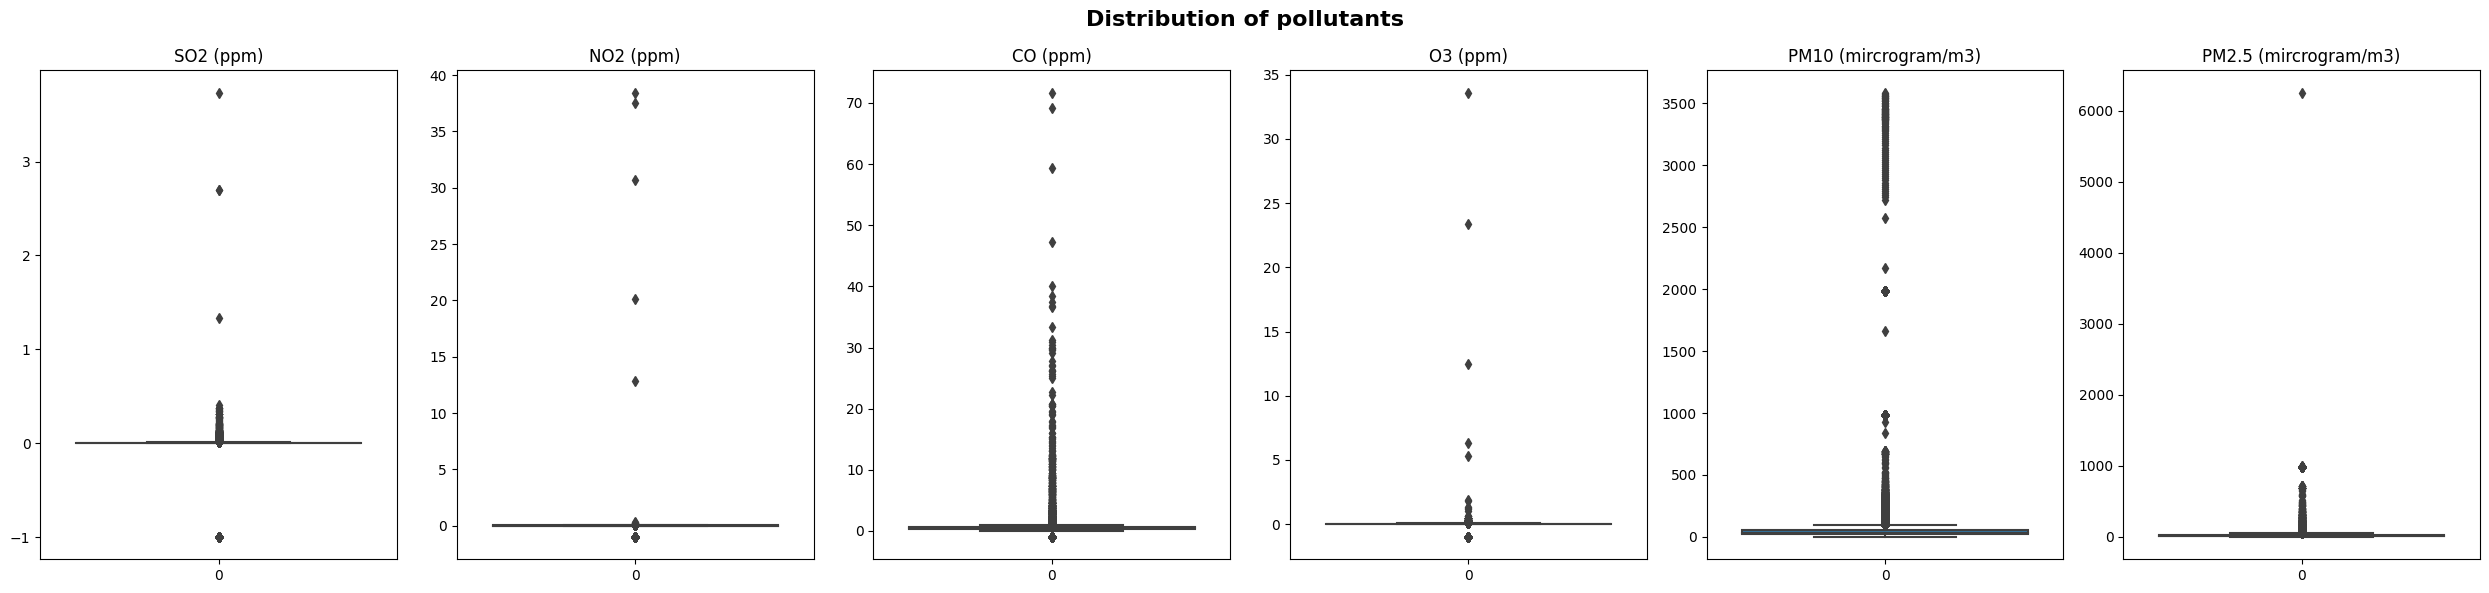

In [8]:
# 박스플롯 시각화
fig, ax = plt.subplots(1, len(pollutants), figsize=(25, 6))
fig.suptitle('Distribution of pollutants', fontsize=16, fontweight='bold')

for n, pollutant in enumerate(pollutants.keys()):
    colname = pollutants[pollutant]
    sns.boxplot(data=df_summary[colname], ax=ax[n])
    ax[n].set_title(pollutant)

plt.tight_layout()
plt.show()

서울특별시 대기환경정보에서 제공한 통합대기환경지수를 기준으로 분류 및 평가

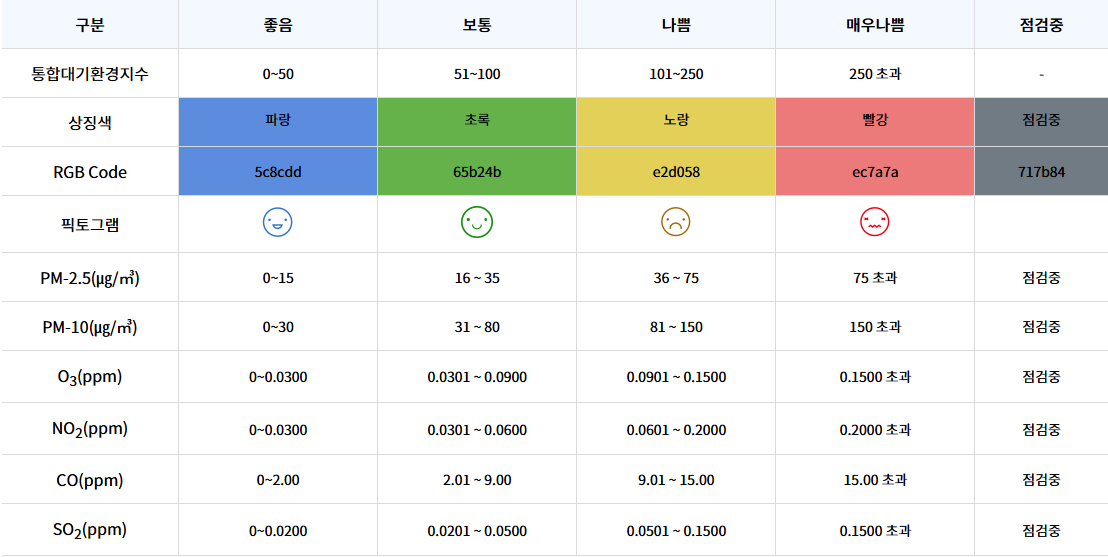

In [9]:
row = df_item.loc[df_item['Item name']=='PM10'].iloc[0]
good_max, normal_max, bad_max = row['Good(Blue)'], row['Normal(Green)'], row['Bad(Yellow)']

In [10]:
def label_pm10(x):
    if   x <= good_max:   return 0  # 좋음
    elif x <= normal_max: return 1  # 보통
    elif x <= bad_max:    return 2  # 나쁨
    else:                 return 3  # 매우나쁨

df_summary['label'] = df_summary['PM10'].apply(label_pm10)

In [11]:
scaler = StandardScaler()
features = [
    'PM10',
    'PM2.5',
    'O3',
    'NO2',
    'CO',
    'SO2'
]
df_summary[features] = scaler.fit_transform(df_summary[features])

In [12]:
class AirDataset(Dataset):
    def __init__(self, df, window=24):
        self.df = df
        self.win= window
    def __len__(self):
        return len(self.df) - self.win
    def __getitem__(self, i):
        seq = self.df.iloc[i:i+self.win][features].values
        x   = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)  # (1, win, feat)
        y   = int(self.df.iloc[i+self.win]['label'])
        return x, y

In [22]:
ds = AirDataset(df_summary, window=24)
dl = DataLoader(ds, batch_size=128, shuffle=True)

In [17]:
model = torchvision.models.resnet18(weights=None)
model.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
model.fc    = nn.Linear(model.fc.in_features, 4)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
epochs     = 5
print_freq = 50   # 몇 배치마다 출력할지
device     = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
class_weights = torch.tensor([1.0, 1.0, 3.0, 10.0], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for batch_idx, (x, y) in enumerate(dl, 1):
        x, y = x.to(device), y.to(device)

        # forward
        outputs = model(x)
        loss    = criterion(outputs, y)

        # backward + step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 통계 집계
        batch_loss = loss.item()
        epoch_loss += batch_loss

        # 중간 출력
        if batch_idx % print_freq == 0 or batch_idx == len(dl):
            elapsed = time.time() - start_time
            print(f"[Epoch {epoch:02d}/{epochs:02d}] "
                  f"Batch {batch_idx:03d}/{len(dl):03d}  "
                  f"Loss: {batch_loss:.4f}  "
                  f"Avg: {epoch_loss/batch_idx:.4f}  "
                  f"Elapsed: {elapsed:.1f}s")

    # 에폭 종료 후 요약
    avg_loss = epoch_loss / len(dl)
    print(f"→ Epoch {epoch:02d} 완료  평균손실: {avg_loss:.4f}  "
          f"소요시간: {time.time()-start_time:.1f}s\n")

[Epoch 01/05] Batch 050/5059  Loss: 0.3644  Avg: 0.4362  Elapsed: 6.2s
[Epoch 01/05] Batch 100/5059  Loss: 0.3148  Avg: 0.3870  Elapsed: 12.1s
[Epoch 01/05] Batch 150/5059  Loss: 0.3238  Avg: 0.3846  Elapsed: 17.9s
[Epoch 01/05] Batch 200/5059  Loss: 0.1942  Avg: 0.3773  Elapsed: 23.7s
[Epoch 01/05] Batch 250/5059  Loss: 0.2586  Avg: 0.3777  Elapsed: 29.5s
[Epoch 01/05] Batch 300/5059  Loss: 0.2933  Avg: 0.3725  Elapsed: 35.4s
[Epoch 01/05] Batch 350/5059  Loss: 0.4802  Avg: 0.3674  Elapsed: 41.2s
[Epoch 01/05] Batch 400/5059  Loss: 0.2948  Avg: 0.3614  Elapsed: 47.0s
[Epoch 01/05] Batch 450/5059  Loss: 0.3978  Avg: 0.3583  Elapsed: 52.8s
[Epoch 01/05] Batch 500/5059  Loss: 0.5700  Avg: 0.3579  Elapsed: 58.6s
[Epoch 01/05] Batch 550/5059  Loss: 0.2609  Avg: 0.3579  Elapsed: 64.6s
[Epoch 01/05] Batch 600/5059  Loss: 0.2739  Avg: 0.3580  Elapsed: 70.4s
[Epoch 01/05] Batch 650/5059  Loss: 0.3507  Avg: 0.3594  Elapsed: 76.2s
[Epoch 01/05] Batch 700/5059  Loss: 0.1863  Avg: 0.3573  Elapsed:

In [30]:
torch.save(model.state_dict(), 'pm10_resnet.pth')
# 혼동행렬·F1-score 계산

In [31]:
# 1) 평가용 DataLoader 준비 (shuffle=False)
eval_ds = AirDataset(df_summary, window=24)
eval_dl = DataLoader(eval_ds, batch_size=64, shuffle=False,
                     num_workers=4, pin_memory=True)

# 2) 모델 불러오기
model = torchvision.models.resnet18(weights=None)
model.conv1 = nn.Conv2d(1,64,7,2,3,bias=False)
model.fc    = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load('pm10_resnet.pth'))
model.to(device).eval()

# 3) 예측·정답 수집
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in eval_dl:
        x = x.to(device)
        logits = model(x)
        preds  = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

# 4) 혼동행렬·F1-score 계산 및 출력
cm     = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred,
                               target_names=['좋음','보통','나쁨','매우나쁨'])

print("=== Confusion Matrix ===")
print(cm)
print("\n=== Classification Report ===")
print(report)

=== Confusion Matrix ===
[[227652  41685    159    442]
 [ 14963 300086   5079    631]
 [   142  10740  38055    596]
 [   396    464   2139   4258]]

=== Classification Report ===
              precision    recall  f1-score   support

          좋음       0.94      0.84      0.89    269938
          보통       0.85      0.94      0.89    320759
          나쁨       0.84      0.77      0.80     49533
        매우나쁨       0.72      0.59      0.65      7257

    accuracy                           0.88    647487
   macro avg       0.84      0.78      0.81    647487
weighted avg       0.88      0.88      0.88    647487

